In [45]:
import numpy as np
import pandas as pd

from scipy import optimize
from scipy import fft
from scipy.interpolate import UnivariateSpline

import matplotlib.pyplot as plt
import pylab as pl
%matplotlib inline

1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



the maximum wind speed occurring every 50 years is: 32.97989844019469


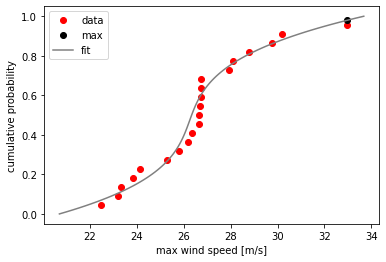

In [46]:
#exercise 1

max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
    
#cumulative probability
cprob = [i/(years_nb+1) for i in range(1, years_nb+1)]   

#sort the maximum speeds 
sorted_max_speeds = np.sort(max_speeds)

#define a quantile function using UnivariateSpline
quantile_func = UnivariateSpline(cprob, sorted_max_speeds)   
fifty_prob = 1. - 0.02
fifty_wind = quantile_func(fifty_prob)
print('the maximum wind speed occurring every 50 years is:',fifty_wind)

#to visualize
plt.plot(sorted_max_speeds, cprob, 'ro', label='data')

nprob = np.linspace(0, 1, 100)
fitted_max_speeds = quantile_func(nprob)
plt.plot(fifty_wind, fifty_prob, 'ko', label='max')

plt.plot(fitted_max_speeds, nprob, color ='gray', label='fit')
plt.xlabel('max wind speed [m/s]')
plt.ylabel('cumulative probability')
plt.legend(loc='best')

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

fit function used is: A + Bsin(2pi*C*x +D)
parameters for max temperatures: 
 [A,B,C,D] = [27.949635 10.5817    1.094263 10.747715]
parameters for min temperatures: 
 [A,B,C,D] = [-36.71257  -25.14962    1.095703 -24.10825 ]


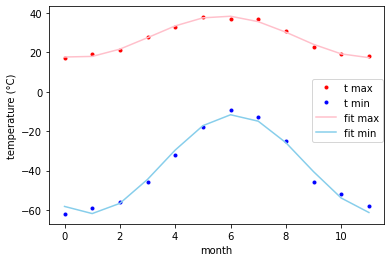

In [47]:
#exercise 2

#plot the temperatures
M = np.array([17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18])
m = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
month = np.arange(12)

#plot the temperatures
plt.plot(month, M, 'r.', label ='t max')
plt.plot(month, m, 'b.', label ='t min')
plt.xlabel('month')
plt.ylabel('temperature (°C)')

#Define a function that can describe min and max temperatures.
#Fit this function to the data with scipy.optimize.curve_fit()
def func(x,A,B,C,D):
    return A + B*np.sin(2*np.pi*x*C + D) 
print('fit function used is: A + Bsin(2pi*C*x +D)')

popt_M, pcov_M = optimize.curve_fit(func, month, M)      
plt.plot(month, func(month, *popt_M), label='fit max', color= 'pink')
print('parameters for max temperatures: \n [A,B,C,D] =',popt_M)

popt_m, pcov_m = optimize.curve_fit(func, month, m)
plt.plot(month, func(month, *popt_m), label='fit min', color = 'skyblue')
print('parameters for min temperatures: \n [A,B,C,D] =',popt_m)

plt.legend(bbox_to_anchor=(0.77, 0.69))

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


the closest minimum to [-1.75, -0.75] is:
 m = [ 0.089842 -0.712656] , f(m) = -1.0316284534898161 

the closest minimum to [0, -0.75] is:
 m = [ 0.089842 -0.712656] , f(m) = -1.0316284534898772 

the closest minimum to [0, 0.75] is:
 m = [-0.089842  0.712656] , f(m) = -1.031628453489877 

the closest minimum to [1.75, 0.75] is:
 m = [-0.089842  0.712656] , f(m) = -1.0316284534898161 

so the global minima are 2: 
 [ 0.089842 -0.712656] [-0.089842  0.712656] 

for an initial guess of (𝑥,𝑦)=(0,0), the minimum found is the local one: [0. 0.]


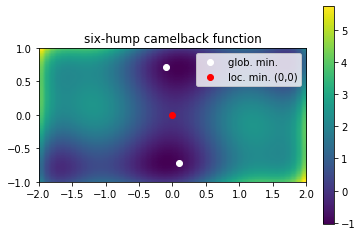

In [48]:
#exercise3
%precision 6

def f(v):
    return (4 - 2.1*v[0]**2 + (v[0]**4)/3)*v[0]**2 + v[0]*v[1] + (4*v[1]**2 - 4)*v[1]**2

# restricted variables
x = np.linspace(-2, 2)
y = np.linspace(-1, 1)

# numpy.meshgrid() and pylab.imshow() to find visually the regions
xv, yv = np.meshgrid(x,y)
pl.imshow(f([xv,yv]),extent=[-2, 2, -1, 1])
plt.colorbar()
plt.title('six-hump camelback function')

# scipy.optimize.minimize() to find min.
points = [[-1.75,-0.75], [0,-0.75], [0,0.75], [1.75,0.75]]            #region with most probable presence of local min.
glob_min = []
for i in points:
    sol = optimize.minimize(f, x0=i)
    print('the closest minimum to',i,'is:\n m =', sol.x,', f(m) =', sol.fun, '\n')
    glob_min.append(sol.x)   

print('so the global minima are 2: \n',glob_min[0],glob_min[3], '\n')  #only 2 global min
plt.scatter(*glob_min[0], color = 'w', label = 'glob. min.')
plt.scatter(*glob_min[3], color = 'w')

# What happens for an initial guess of  (𝑥,𝑦)=(0,0)  ?
sol_0 = optimize.minimize(f, x0=[0,0])
print('for an initial guess of (𝑥,𝑦)=(0,0), the minimum found is the local one:', sol_0.x )
plt.scatter(*sol_0.x, color = 'r', label = 'loc. min. (0,0)') 
plt.legend(loc ='best')


4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

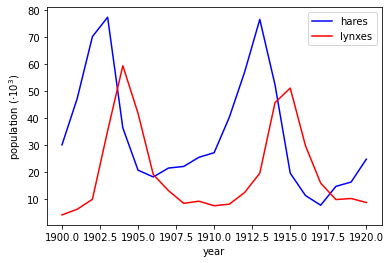

In [54]:
#exercise4

#data
data = np.array(np.loadtxt("populations.txt")[:, :],'uint32')

year = data[:,0]
hares = data[:,1]
lynxes = data[:,2]
plt.plot( year, hares * 1e-3, label = "hares", color='b')
plt.plot( year, lynxes* 1e-3, label = "lynxes", color='r')
plt.xlabel('year')
plt.ylabel('population ($\cdot10^3$)')
plt.legend(loc ="best")

the period of the 2 populations is about 10 years


<ipython-input-50-e6502be3c703>:3: RuntimeWarning: divide by zero encountered in true_divide
  period_H = 1 / freq_H
<ipython-input-50-e6502be3c703>:7: RuntimeWarning: divide by zero encountered in true_divide
  period_L = 1 / freq_L


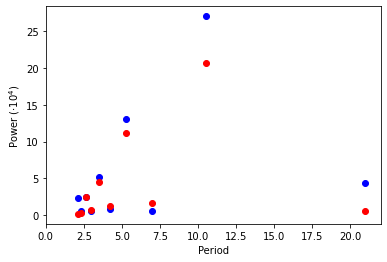

In [50]:
ft_H = fft.fft(hares, axis=0)
freq_H = fft.fftfreq(hares.shape[0], year[1] - year[0])
period_H = 1 / freq_H

ft_L = fft.fft(lynxes, axis=0)
freq_L = fft.fftfreq(lynxes.shape[0], year[1] - year[0])
period_L = 1 / freq_L

plt.plot(period_H, abs(ft_H) * 1e-4, 'bo')
plt.plot(period_L, abs(ft_L) * 1e-4, 'ro')
plt.xlim(0, 22)
plt.xlabel('Period')
plt.ylabel('Power ($\cdot10^4$)')

print('the period of the 2 populations is about 10 years')

C:\Users\hp\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\hp\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


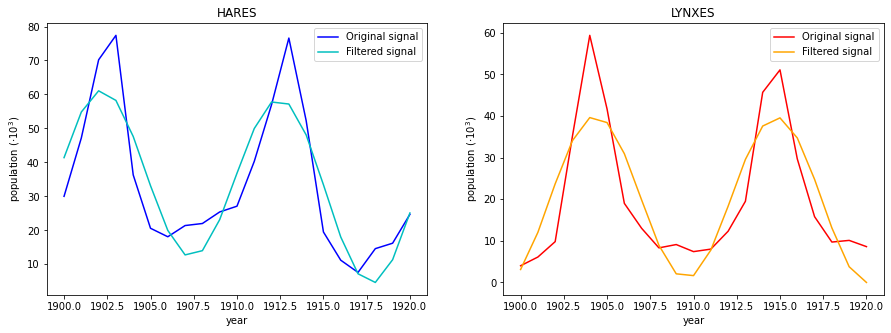

In [51]:
#HARES
pos_mask = np.where(freq_H > 0)
freqs = freq_H[pos_mask]
peak_freq = freqs[power_H[pos_mask].argmax()]

high_freq_fft = fft_H.copy()
high_freq_fft[np.abs(freq_H) > peak_freq] = 0
filtered_sig_H = fft.ifft(high_freq_fft)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax1.plot(year, hares* 1e-3, label='Original signal', color='b')
ax1.plot(year, filtered_sig_H* 1e-3, label='Filtered signal', color='c')
ax1.set_xlabel('year')
ax1.set_ylabel('population ($\cdot10^3$)')
ax1.set_title('HARES')
ax1.legend(loc='best')

#LYNXES
pos_mask = np.where(freq_L > 0)
freqs = freq_L[pos_mask]
peak_freq = freqs[power_L[pos_mask].argmax()]

high_freq_fft = fft_L.copy()
high_freq_fft[np.abs(freq_L) > peak_freq] = 0
filtered_sig_L = fft.ifft(high_freq_fft)

ax2.plot(year, lynxes* 1e-3, label='Original signal', color='r')
ax2.plot(year, filtered_sig_L* 1e-3, label='Filtered signal', color='orange')
ax2.set_xlabel('year')
ax2.set_ylabel('population ($\cdot10^3$)')
ax2.set_title('LYNXES')
ax2.legend(loc='best')

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

Text(0.5, 1.0, 'Filtered Image')

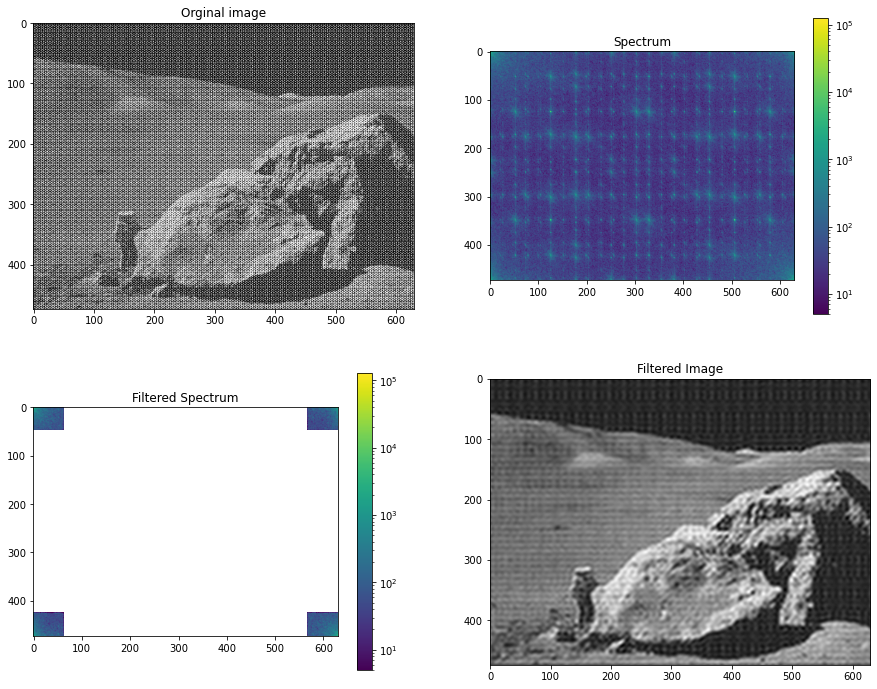

In [52]:
#exercise 5
from matplotlib.colors import LogNorm

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

# original image
img = plt.imread('moonlanding.png')  
ax1.imshow(img, plt.cm.gray) 
ax1.set_title('Orginal image')

# fft2 
FFT_img = fft.fft2(img)
fig2 = ax2.imshow(np.abs(FFT_img), norm=LogNorm(vmin=5))
plt.colorbar(fig2, ax=ax2)
ax2.set_title('Spectrum')

# set some of the components of the spectrum to zero (use array slicing)
FFT_img = FFT_img.copy()

r, c = FFT_img.shape         # rows and columns of the array
coeff = 0.1                  # fraction of coefficients to keep

FFT_img[int(r*coeff):int(r*(1-coeff))] = 0       #portions of rows setted to zero
FFT_img[:, int(c*coeff):int(c*(1-coeff))] = 0    #portions of columns setted to zero

fig3 = ax3.imshow(np.abs(FFT_img), norm=LogNorm(vmin=5))
plt.colorbar(fig3, ax=ax3)
ax3.set_title('Filtered Spectrum')

# inverse Fourier transform to see the resulting image
img_new = fft.ifft2(FFT_img).real

ax4.imshow(img_new, plt.cm.gray)
ax4.set_title('Filtered Image')